In [1]:
!nvidia-smi

Fri Jul 10 19:26:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.39       Driver Version: 418.39       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:04:00.0 Off |                  N/A |
| 41%   26C    P8    15W / 280W |   2321MiB / 24190MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:05:00.0 Off |                  N/A |
| 60%   74C    P2    68W / 280W |  12167MiB / 24190MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
######### IMPORTING NECESSARY MODULES #########
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import sys
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import transforms, datasets, models
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


**Dataloading Scheme**

In [4]:
trainlist = '/home/sreena/shayeree/training/trainlatest.txt'
validlist ='/home/sreena/shayeree/training/validlatest.txt'

In [5]:
# Create a mapping of Unique product Ids to Labels(0 to 31127 classes)
# output = dictionary containing mapping of each upc to a label from (0 to 31127)  

with open(validlist, mode = 'r') as f:
    
    Y=[]
    for line in f:
        path, UPC = line[:-1].split(',')

        Y.append(UPC)
        
prime_number_list = sorted(set(Y))

prime_number_dict = { prime_number_list[i] :i for i in range(0, len(prime_number_list) ) }

In [6]:
len(prime_number_dict)

1983

In [7]:
class mydataset():    

    def __init__(self, classification_list, prime_number_dict, name):

        super(mydataset).__init__()
        
        self.X = []
        self.Y = []
        
        with open(classification_list, mode = 'r') as f:
            
            for line in f:
                path, Prime_Number = line[:-1].split(',')

                self.X.append(path)
                self.Y.append(prime_number_dict[Prime_Number])
        

        if name == 'valid':
            self.transform = transforms.Compose([   transforms.Resize(256),
                                                    transforms.CenterCrop(224),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                    std=[0.229, 0.224, 0.225])
                                                ])
        else:
            self.transform = transforms.Compose([transforms.RandomResizedCrop(221,127),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                    std=[0.229, 0.224, 0.225])])
            
    def __getitem__(self,index):
        
        image = self.X[index]        
        label = float(self.Y[index])
        
        image = (Image.open(image))
               
        image = self.transform(image)
        
        return image, torch.as_tensor(label).long()
        
  
    def __len__(self):
        return len(self.X)

In [8]:
# #### Train Dataloader #### 
train_dataset = mydataset(trainlist, prime_number_dict, name='train')          
train_dataloader = data.DataLoader(train_dataset, shuffle= True, batch_size = 128, num_workers=16,pin_memory=True)


#### Validation Dataloader ##
validation_dataset = mydataset(validlist, prime_number_dict, name='valid')         
validation_dataloader = data.DataLoader(validation_dataset, shuffle=True, batch_size = 128, num_workers=16,pin_memory=True)

**RESNET Architecture**

**Model Definition**

In [9]:
import torch.nn as nn
import math

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * Bottleneck.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * Bottleneck.expansion)
        self.relu = nn.ReLU(inplace=True)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, depth, num_classes, bottleneck=False):
        super(ResNet, self).__init__()        
        
        
        blocks ={18: BasicBlock, 34: BasicBlock, 50: Bottleneck, 101: Bottleneck, 152: Bottleneck, 200: Bottleneck}
        layers ={18: [2, 2, 2, 2], 34: [3, 4, 6, 3], 50: [3, 4, 6, 3], 101: [3, 4, 23, 3], 152: [3, 8, 36, 3], 200: [3, 24, 36, 3]}
        assert layers[depth], 'invalid detph for ResNet (depth should be one of 18, 34, 50, 101, 152, and 200)'

        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(blocks[depth], 64, layers[depth][0])
        self.layer2 = self._make_layer(blocks[depth], 128, layers[depth][1], stride=2)
        self.layer3 = self._make_layer(blocks[depth], 256, layers[depth][2], stride=2)
        self.layer4 = self._make_layer(blocks[depth], 512, layers[depth][3], stride=2)
        self.avgpool = nn.AvgPool2d(7) 
        self.fc = nn.Linear(512 * blocks[depth].expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
    
        return x


**Initialize the model**

In [10]:
model = ResNet(depth = 50, num_classes = 1983)
model = nn.DataParallel(model,device_ids=[0,3]).to(device)
model

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

**Helper function for Cutmix
https://arxiv.org/pdf/1905.04899v2.pdf**

In [11]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [12]:
for batch_num, (feats, target) in enumerate(train_dataloader):
    print(batch_num)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/sreena/abhishek/anaconda3/envs/Abhishek/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/home/sreena/abhishek/anaconda3/envs/Abhishek/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sreena/abhishek/anaconda3/envs/Abhishek/lib/python3.7/site-packages/torch/utils/data/_utils/pin_memory.py", line 25, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/home/sreena/abhishek/anaconda3/envs/Abhishek/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/home/sreena/abhishek/anaconda3/envs/Abhishek/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 294, in rebuild_storage_fd
    fd = df.detach()
  File "/home/sreena/abhishek/anaconda3/envs/Abhishek/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    wit

KeyboardInterrupt: 

**Training Method**

In [13]:
def train(model, data_loader, test_loader,beta, cutmix_prob, epochs):
    model.train()

    for epoch in range(epochs):
        avg_loss = 0.0
                
        
        for batch_num, (feats, target) in enumerate(data_loader):
            feats, target = feats.to(device), target.to(device)
            
            
            r = np.random.rand(1)
            if beta > 0 and r < cutmix_prob:
                # generate mixed sample
                lam = np.random.beta(beta, beta)
                rand_index = torch.randperm(feats.size()[0]).to(device)
                target_a = target
                target_b = target[rand_index]
                bbx1, bby1, bbx2, bby2 = rand_bbox(feats.size(), lam)
                feats[:, :, bbx1:bbx2, bby1:bby2] = feats[rand_index, :, bbx1:bbx2, bby1:bby2]
                # adjust lambda to exactly match pixel ratio
                lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (feats.size()[-1] * feats.size()[-2]))
                # compute output
                output = model(feats)
                loss = criterion(output, target_a) * lam + criterion(output, target_b) * (1. - lam)
            else:
                # compute output
                output = model(feats)
                loss = criterion(output, target)


                                  
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_loss += loss.item()

            if batch_num % 100 == 99:
                print('loss', avg_loss/100)

            del feats
            del target
            del loss

        lr_scheduler.step()

        print('Epoch: ', epoch+90)

        print('training loss = ', avg_loss/len(data_loader))
        train_loss.append(avg_loss/len(data_loader))

        ## Check performance on validation set after an Epoch
        valid_loss, valid_acc = test_classify(model, test_loader)
        print('Val Loss: {:.4f}\tVal Accuracy: {:.4f}'.format(valid_loss, valid_acc))
        v_loss.append(valid_loss)
        v_acc.append(valid_acc)

        #########save model checkpoint #########
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'Training_Loss_List':train_loss,
            'Validation_Loss_List':v_loss,
            'Validation_Accuracy_List': v_acc,
            'Epoch':epoch,
            'lr_scheduler': lr_scheduler.state_dict() 

            }, 'saved_model_checkpoints/cutmix_check')


def test_classify(model, test_loader):
    model.eval()
    test_loss = []
    accuracy = 0
    total = 0

    for batch_num, (feats, labels) in enumerate(test_loader):
        feats, labels = feats.to(device), labels.to(device)
        outputs = model(feats)
        
        _, pred_labels = torch.max(F.softmax(outputs, dim=1), 1)
        pred_labels = pred_labels.view(-1)
        
        loss = criterion(outputs, labels.long())
        
        accuracy += torch.sum(torch.eq(pred_labels, labels)).item()
        total += len(labels)
        test_loss.extend([loss.item()]*feats.size()[0])
        del feats
        del labels

    model.train()
    return np.mean(test_loss), accuracy/total



**Hyperparameters**

In [14]:
# # Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4, momentum=0.9)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 30, gamma = 0.1)


# Epochs
num_Epochs = 120

beta=1

cutmix_prob = 1

In [15]:
train_loss= []
v_loss = []
v_acc = []

**Train the model**

In [19]:
train(model, train_dataloader, validation_dataloader, beta, cutmix_prob, epochs = num_Epochs)

loss 7.2148092031478885
loss 14.341025700569153
loss 21.35782360076904
loss 28.257205891609193
loss 35.088924446105956
loss 41.80571895122528
loss 48.489325423240665
loss 55.0381794166565
Epoch:  90
training loss =  6.8777213658647565
Val Loss: 5.8826	Val Accuracy: 0.0435
loss 6.468389601707458
loss 12.847163124084473
loss 19.149465851783752
loss 25.35991680622101
loss 31.47093258857727
loss 37.551034955978395
loss 43.54356248378754
loss 49.40811885356903
Epoch:  91
training loss =  6.1712828960371375
Val Loss: 4.7943	Val Accuracy: 0.1479
loss 5.777833337783814
loss 11.431666040420533
loss 17.064396457672117
loss 22.720531458854676
loss 28.303070406913758
loss 33.73212287425995
loss 39.121845555305484
loss 44.39937112808227
Epoch:  92
training loss =  5.5489184501449165
Val Loss: 3.9860	Val Accuracy: 0.2513
loss 5.362016921043396
loss 10.597388741970063
loss 15.76799123287201
loss 20.884542260169983
loss 26.058606629371642
loss 31.122168023586273
loss 36.202241876125335
loss 41.2556397

loss 8.577195950746535
loss 11.397340859174728
loss 14.217380722761154
loss 17.048788912296295
loss 19.819331021308898
loss 22.675104615688323
Epoch:  121
training loss =  2.8340303471898913
Val Loss: 1.8595	Val Accuracy: 0.6398
loss 2.7192617297172545
loss 5.469751622676849
loss 8.264502367973328
loss 11.05053168296814
loss 13.835636205673218
loss 16.61535187244415
loss 19.348664740324022
loss 22.152438806295393
Epoch:  122
training loss =  2.767621714631026
Val Loss: 1.8431	Val Accuracy: 0.6448
loss 2.754331647157669
loss 5.472481881380081
loss 8.175870994329452
loss 10.861743577718734
loss 13.682652022838592
loss 16.537261724472046
loss 19.327142775058746
loss 22.01894266605377
Epoch:  123
training loss =  2.750700879037824
Val Loss: 1.8355	Val Accuracy: 0.6422
loss 2.727191789150238
loss 5.464715194702149
loss 8.19333613872528
loss 10.956606801748276
loss 13.738449296951295
loss 16.44236946105957
loss 19.041466143131256
loss 21.693695114850996
Epoch:  124
training loss =  2.7120806

Val Loss: 1.7336	Val Accuracy: 0.6608
loss 2.374937846660614
loss 4.784274337291717
loss 7.177336478233338
loss 9.553579051494598
loss 11.929336253404617
loss 14.307536189556123
loss 16.700730129480363
loss 18.99548647761345
Epoch:  152
training loss =  2.372697598880929
Val Loss: 1.7364	Val Accuracy: 0.6618
loss 2.3712935602664946
loss 4.669722932577133
loss 7.03779641032219
loss 9.43564319729805
loss 11.77578954577446
loss 14.213316274881363
loss 16.52931386590004
loss 18.8707906126976
Epoch:  153
training loss =  2.3601548991191477
Val Loss: 1.7341	Val Accuracy: 0.6626
loss 2.37903804063797
loss 4.747319940328598
loss 7.0719642674922945
loss 9.45047421693802
loss 11.75634888291359
loss 14.03437001824379
loss 16.34028234601021
loss 18.735947316884996
Epoch:  154
training loss =  2.3430602903993196
Val Loss: 1.7308	Val Accuracy: 0.6606
loss 2.3182801103591917
loss 4.668139681816101
loss 6.900047614574432
loss 9.23240178823471
loss 11.546870628595352
loss 13.886225910186768
loss 16.219

loss 18.121494200229645
Epoch:  182
training loss =  2.2647578427868504
Val Loss: 1.7210	Val Accuracy: 0.6643
loss 2.255713794231415
loss 4.531441926956177
loss 6.860946036577225
loss 9.128493280410767
loss 11.408196099996566
loss 13.623343216180801
loss 15.944934611320496
loss 18.257628885507582
Epoch:  183
training loss =  2.2828176218286047
Val Loss: 1.7163	Val Accuracy: 0.6642
loss 2.3059267628192903
loss 4.530176995992661
loss 6.783455077409744
loss 8.943127267360687
loss 11.231131263971328
loss 13.56246573805809
loss 15.728466376066208
loss 18.013466209173203
Epoch:  184
training loss =  2.2532899159355733
Val Loss: 1.7216	Val Accuracy: 0.6651
loss 2.2817860519886017
loss 4.560422768592835
loss 6.8100070226192475
loss 9.052884463071823
loss 11.326839796304704
loss 13.65061038017273
loss 15.900521461963654
loss 18.170349310040475
Epoch:  185
training loss =  2.2727140777608006
Val Loss: 1.7176	Val Accuracy: 0.6656
loss 2.3209534168243406
loss 4.541109006404877
loss 6.8059223330020

**Load saved model from checkpoint**

In [21]:
checkpoint = torch.load('saved_model_checkpoints/cutmix_check')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
train_loss = checkpoint['Training_Loss_List'] 
v_loss = checkpoint['Validation_Loss_List']
v_acc = checkpoint['Validation_Accuracy_List']
epoch = checkpoint['Epoch']


**Generate plots**

Text(0.5, 1.0, 'Validation Accuracy v/s Epochs')

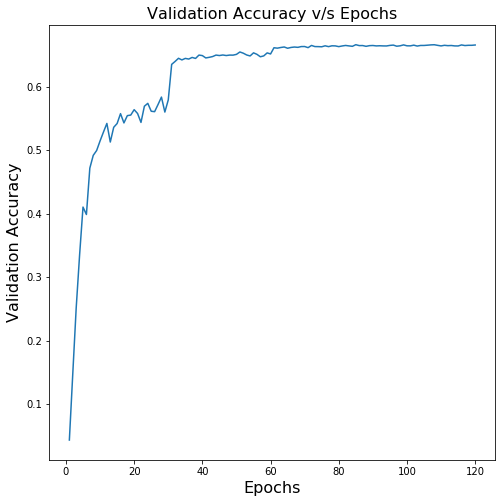

In [21]:
plt.figure(figsize=(8,8))
x = np.arange(1,121)
plt.plot(x, v_acc)
plt.xlabel('Epochs', fontsize =16)
plt.ylabel('Validation Accuracy', fontsize =16)
plt.title('Validation Accuracy v/s Epochs',fontsize =16)


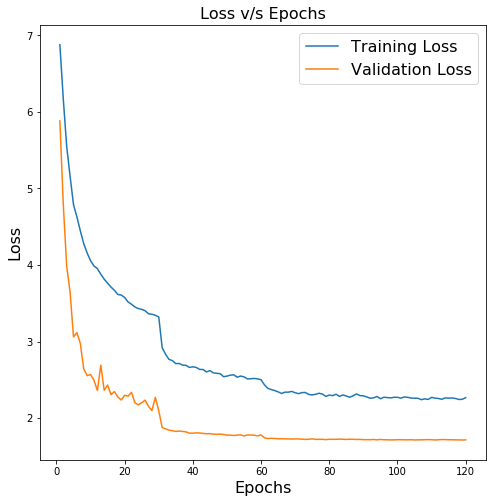

In [22]:
plt.figure(figsize=(8,8))
x = np.arange(1,121)
plt.plot(x, train_loss, label = 'Training Loss')
plt.plot(x, v_loss, label = 'Validation Loss')
plt.xlabel('Epochs', fontsize =16)
plt.ylabel('Loss', fontsize =16)
plt.title('Loss v/s Epochs',fontsize =16)
plt.legend(fontsize=16)

In [23]:
t_loss, t_acc = test_classify(model, train_dataloader)
print('Train Loss: {:.4f}\tTrain Accuracy: {:.4f}'.format(t_loss, t_acc))

Train Loss: 1.1175	Train Accuracy: 0.7188
